Bug analysis for github issue [Bug fix for first_metric_only on earlystopping](https://github.com/microsoft/LightGBM/pull/2127) .
1. Order of metric list is not fixed even if it is defined by list. So explicitly indicating which metric is used on early stopping.  


2. Due to introducing eval_train_metric feature, if the feature is enabled, then the first metric became train score of the metrics, so it does not appropriate for early stopping. So until the specified metrics of validation is coming, skipping to check early stopping in the loop.  


* reference: Parameters
https://lightgbm.readthedocs.io/en/latest/Parameters.html#metric-parameters


In [1]:
import sys
sys.path = ["/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/"] + sys.path

In [2]:
import traceback
import lightgbm as lgb
import numpy as np
import numpy.random as rd
import pandas as pd
from sklearn.metrics import roc_auc_score, log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection._search import ParameterGrid

from IPython.display import display
from itertools import permutations


# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/__init__.py:47: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
lgb.__file__

'/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/__init__.py'

In [4]:
def test_train(train_func, param_func, dataset):
    num_boost_round = 300
    pg = param_func()
    for p in pg:
        print("="*100, flush=True)
        print("="*100, flush=True)
        print(p, flush=True)
        try:
            df_ret = train_func(dataset, metric_list=p["metric_list"], 
                                 eval_train_metric=p["eval_train_metric"], 
                                 first_metric_only=p["first_metric_only"],
                                 num_boost_round=num_boost_round)
            draw_metric_graph(df_ret)
            if df_ret.shape[0]==num_boost_round:
                raise Exception("early_stopping was not applied.")
        except Exception as e:
            traceback.print_exc()

        print("", flush=True)
        # break
        

def draw_metric_graph(df_ret):
    valid_cols = [c for c in df_ret.columns if c.find("valid")>=0 and c.find("mean")>=0]
    train_cols = [c for c in df_ret.columns if c.find("train")>=0 and c.find("mean")>=0]
    
    if len(valid_cols)==0:
        valid_cols = [c for c in df_ret.columns if c.find("mean")>=0]

    n_graph = len(valid_cols) + len(train_cols)
    n_cols = 3
    n_rows = n_graph//n_cols+1

    plt.figure(figsize=(25, 5*n_rows))
    cnt = 1
    for c in valid_cols:
        plt.subplot(n_rows, n_cols, cnt); cnt += 1
        df_ret[c].plot()
        plt.title(f"{c}")
        # plt.show()


    for c in train_cols:
        plt.subplot(n_rows, n_cols, cnt); cnt += 1
        df_ret[c].plot()
        plt.title(f"{c}")
        #plt.show()
    plt.tight_layout()
    plt.show()
    

In [5]:
import itertools
decreasing_generator = itertools.count(0, -1)    
def decreasing_metric(preds, train_data):
    return ('decreasing_metric', next(decreasing_generator), False)

def constant_metric(preds, train_data):
    return ('constant_metric', 0.0, False)

def custom_evals(preds, train_data): 
    return [decreasing_metric(preds, train_data), constant_metric(preds, train_data)]

# Binary Classification

## Load data

In [6]:
def load_data_for_classification():
    rd.seed(123)
    print('Loading data...')
    # load or create your dataset
    df_train = pd.read_csv('../../examples/binary_classification/binary.train', header=None, sep='\t')
    df_test = pd.read_csv('../../examples/binary_classification/binary.test', header=None, sep='\t')

    print("df_train.shape:{}, df_test.shape:{}".format(df_train.shape, df_test.shape))
    display(df_train.head())

    y_train = df_train[0]
    y_test = df_test[0]
    X_train = df_train.drop(0, axis=1)
    X_test = df_test.drop(0, axis=1)
    return X_train, y_train, X_test, y_test

def classification_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500, feval=None):
    X_train, y_train, X_test, y_test = dataset

    # create dataset for lightgbm
    lgb_train = lgb.Dataset(X_train, y_train)

    # specify your configurations as a dict
    params = {
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': metric_list,
        #'metric': ['auc', 'binary_logloss',],
        'num_leaves': 8,
        'learning_rate': 0.1,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': 0
    }

    res_dict = {}
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)

    # Fitting
    ret = lgb.cv(params=params, feval=custom_evals,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 50,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   # return_boosters=True
                   )

    #print(f"best_iteration : {model.best_iteration}")
    df_ret = pd.DataFrame(ret)
    display(df_ret.tail())
    return df_ret

def classification_params():
    two_metrics = list(permutations(['binary_logloss','auc', ], 2))
    three_metrics = list(permutations(['binary_logloss','auc', "xentropy"], 3))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" :[
                          None, "", "None", "binary_logloss", "auc", "xentropy",  # just one metric
                          
                       ] + two_metrics + three_metrics , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg


Loading data...
df_train.shape:(7000, 29), df_test.shape:(500, 29)


,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1,0.869,-0.635,0.226,0.327,-0.690,0.754,-0.249,-1.092,0.000,...,-0.010,-0.046,3.102,1.354,0.980,0.978,0.920,0.722,0.989,0.877
1,1,0.908,0.329,0.359,1.498,-0.313,1.096,-0.558,-1.588,2.173,...,-1.139,-0.001,0.000,0.302,0.833,0.986,0.978,0.780,0.992,0.798
2,1,0.799,1.471,-1.636,0.454,0.426,1.105,1.282,1.382,0.000,...,1.129,0.900,0.000,0.910,1.108,0.986,0.951,0.803,0.866,0.780
3,0,1.344,-0.877,0.936,1.992,0.882,1.786,-1.647,-0.942,0.000,...,-0.678,-1.360,0.000,0.947,1.029,0.999,0.728,0.869,1.027,0.958
4,1,1.105,0.321,1.522,0.883,-1.205,0.681,-1.070,-0.922,0.000,...,-0.374,0.113,0.000,0.756,1.361,0.987,0.838,1.133,0.872,0.808


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-6-062582b93e8f>", line 55, in classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 228, in _callback
    raise LightGBMError("`metric` should be specified if first_metric_only==True.")
lightgbm.basic.LightGBMError: `metric` should be specified if first_metric_only==True.


[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623
Evaluating only :valid binary_logloss


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


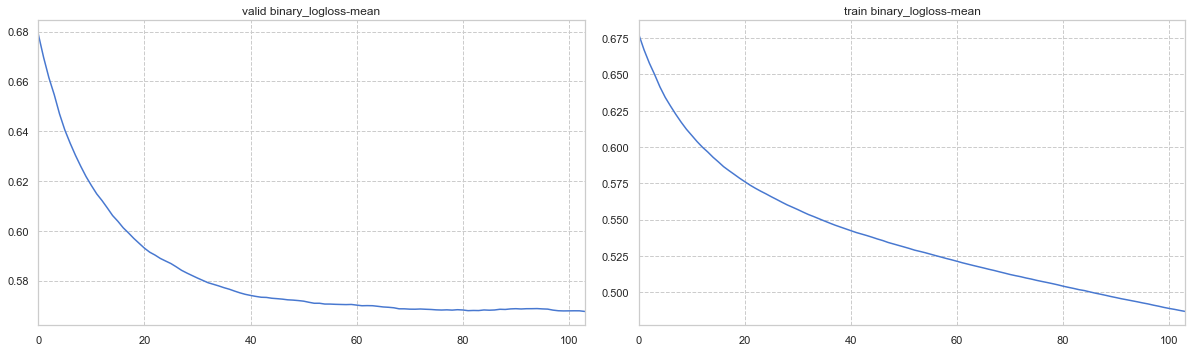


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'binary_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-6-062582b93e8f>", line 55, in classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623
Evaluating only :valid binary_logloss


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


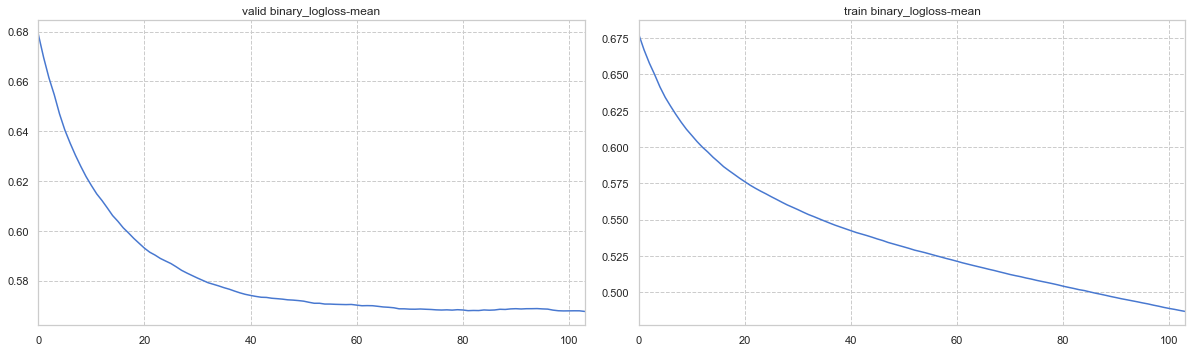


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'auc'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid auc: 0.77113 + 0.0116124
Early stopping, best iteration is:
[82]	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's valid auc: 0.774197 + 0.0137751
Evaluating only :valid auc


,train auc-mean,train auc-stdv,valid auc-mean,valid auc-stdv
77,0.846830,0.002407,0.773952,0.014784
78,0.847386,0.002383,0.774053,0.014320
79,0.848161,0.002385,0.773936,0.014322
80,0.848802,0.002513,0.773933,0.013769
81,0.849456,0.002497,0.774197,0.013775


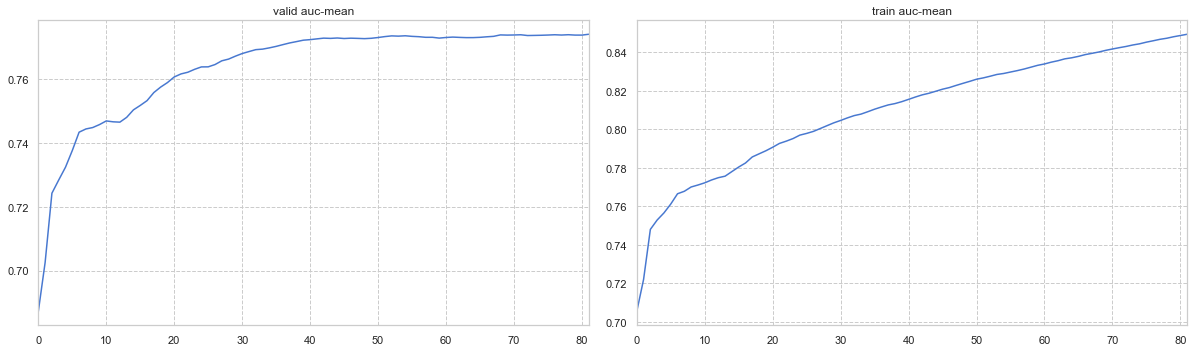


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': 'xentropy'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's valid xentropy: 0.572024 + 0.0108773
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's valid xentropy: 0.567869 + 0.00990152
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's valid xentropy: 0.569961 + 0.00967098
[200]	cv_agg's train xentropy: 0.42645 + 0.00158453	cv_agg's valid xentropy: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train xentropy: 0.486689 + 0.00208938	cv_agg's valid xentropy: 0.567659 + 0.00997623
Evaluating only :valid xentropy


,train xentropy-mean,train xentropy-stdv,valid xentropy-mean,valid xentropy-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


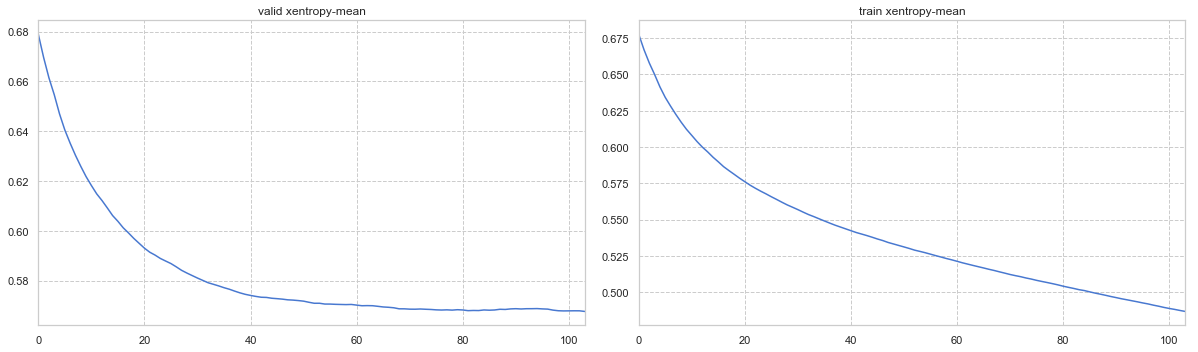


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('binary_logloss', 'auc')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train auc: 0.911222 + 0.00182659	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid auc: 0.769132 + 0.0107175	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train auc: 0.8

,train auc-mean,train auc-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid auc-mean,valid auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.861688,0.002259,0.489460,0.002139,0.773914,0.012689,0.567869,0.009902
100,0.862317,0.002210,0.488741,0.002174,0.773939,0.012767,0.567898,0.009931
101,0.862821,0.002213,0.488106,0.002191,0.773867,0.012762,0.567922,0.009937
102,0.863465,0.002138,0.487379,0.002094,0.773908,0.012827,0.567912,0.009919
103,0.864025,0.002097,0.486689,0.002089,0.774163,0.012813,0.567659,0.009976


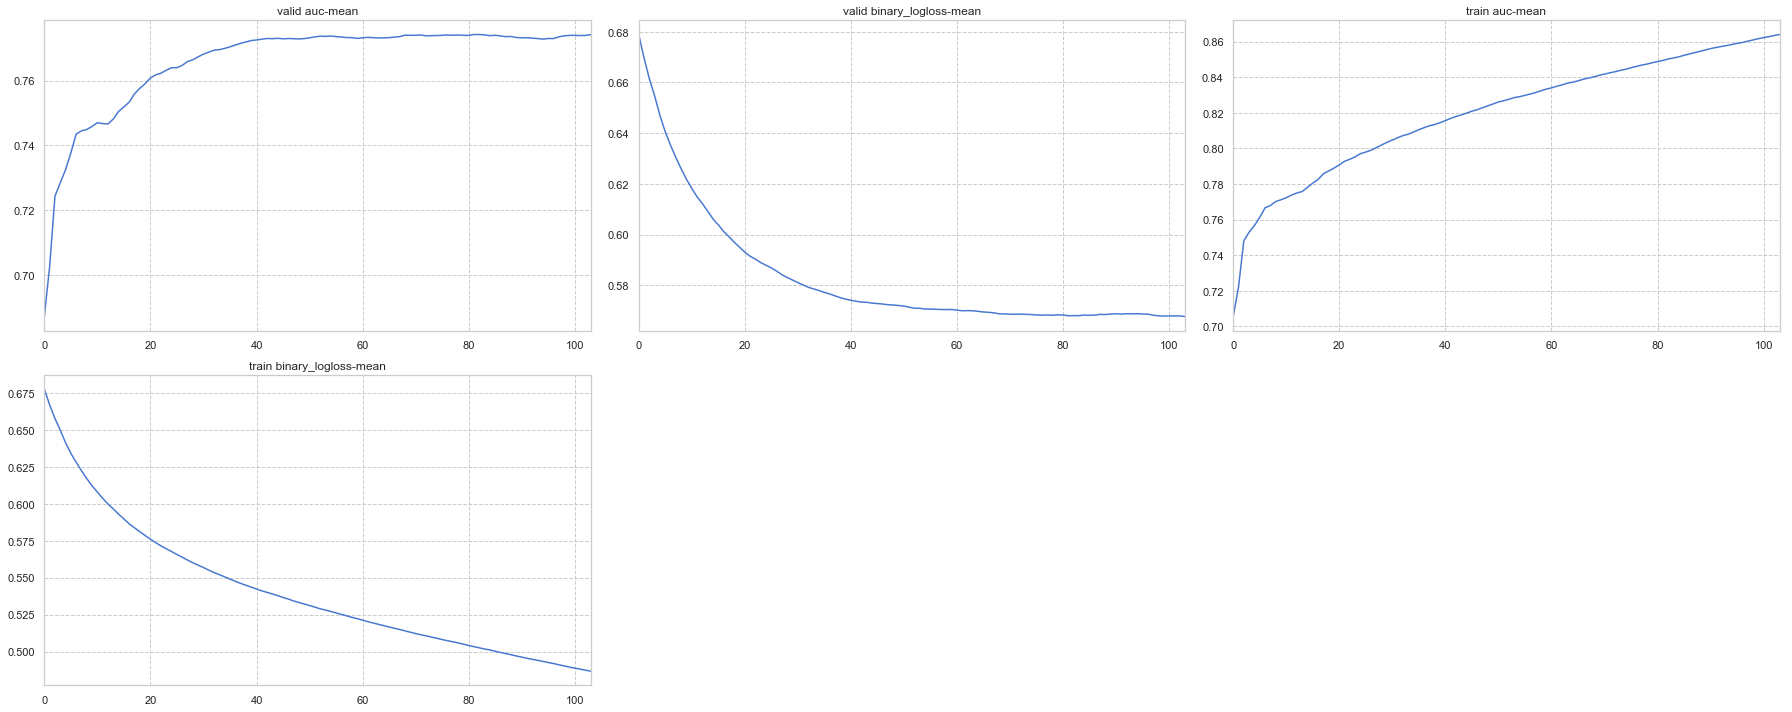


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('auc', 'binary_logloss')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg's valid auc: 0.77113 + 0.0116124
Early stopping, best iteration is:
[82]	cv_agg's train binary_logloss: 0.503292 + 0.00202494	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's valid binary_logloss: 0.567977 + 0.0102463	cv_agg's valid auc: 0.774197 + 0.0137751
Evaluating only :valid auc


,train binary_logloss-mean,train binary_logloss-stdv,train auc-mean,train auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid auc-mean,valid auc-stdv
77,0.506604,0.001793,0.846830,0.002407,0.568303,0.010992,0.773952,0.014784
78,0.505829,0.001881,0.847386,0.002383,0.568192,0.010609,0.774053,0.014320
79,0.505010,0.001906,0.848161,0.002385,0.568357,0.010661,0.773936,0.014322
80,0.504091,0.002040,0.848802,0.002513,0.568247,0.010199,0.773933,0.013769
81,0.503292,0.002025,0.849456,0.002497,0.567977,0.010246,0.774197,0.013775


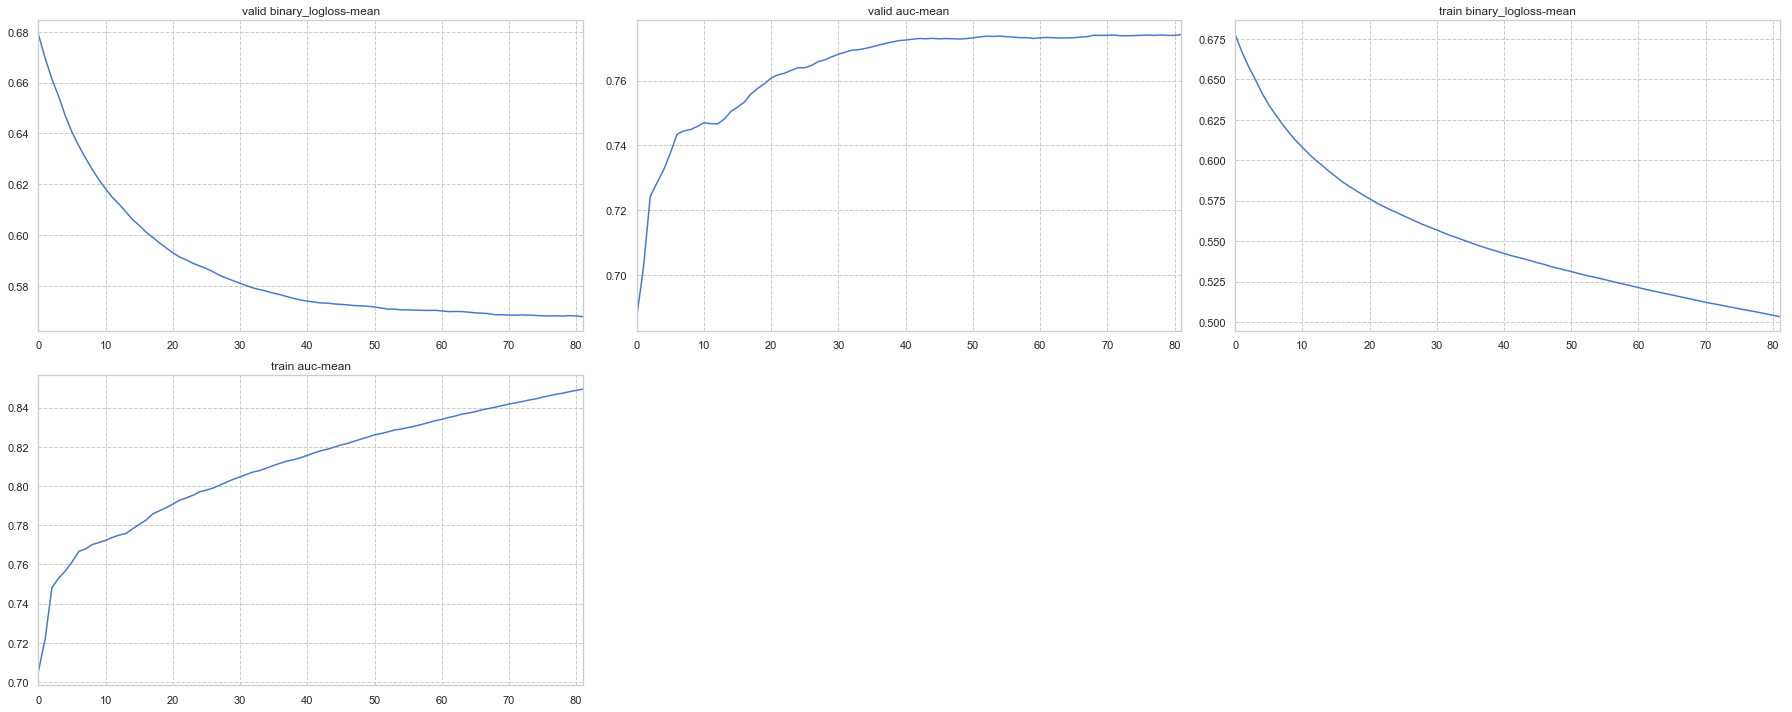


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('binary_logloss', 'auc', 'xentropy')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid bina

,train xentropy-mean,train xentropy-stdv,train auc-mean,train auc-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid xentropy-mean,valid xentropy-stdv,valid auc-mean,valid auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.861688,0.002259,0.489460,0.002139,0.567869,0.009902,0.773914,0.012689,0.567869,0.009902
100,0.488741,0.002174,0.862317,0.002210,0.488741,0.002174,0.567898,0.009931,0.773939,0.012767,0.567898,0.009931
101,0.488106,0.002191,0.862821,0.002213,0.488106,0.002191,0.567922,0.009937,0.773867,0.012762,0.567922,0.009937
102,0.487379,0.002094,0.863465,0.002138,0.487379,0.002094,0.567912,0.009919,0.773908,0.012827,0.567912,0.009919
103,0.486689,0.002089,0.864025,0.002097,0.486689,0.002089,0.567659,0.009976,0.774163,0.012813,0.567659,0.009976


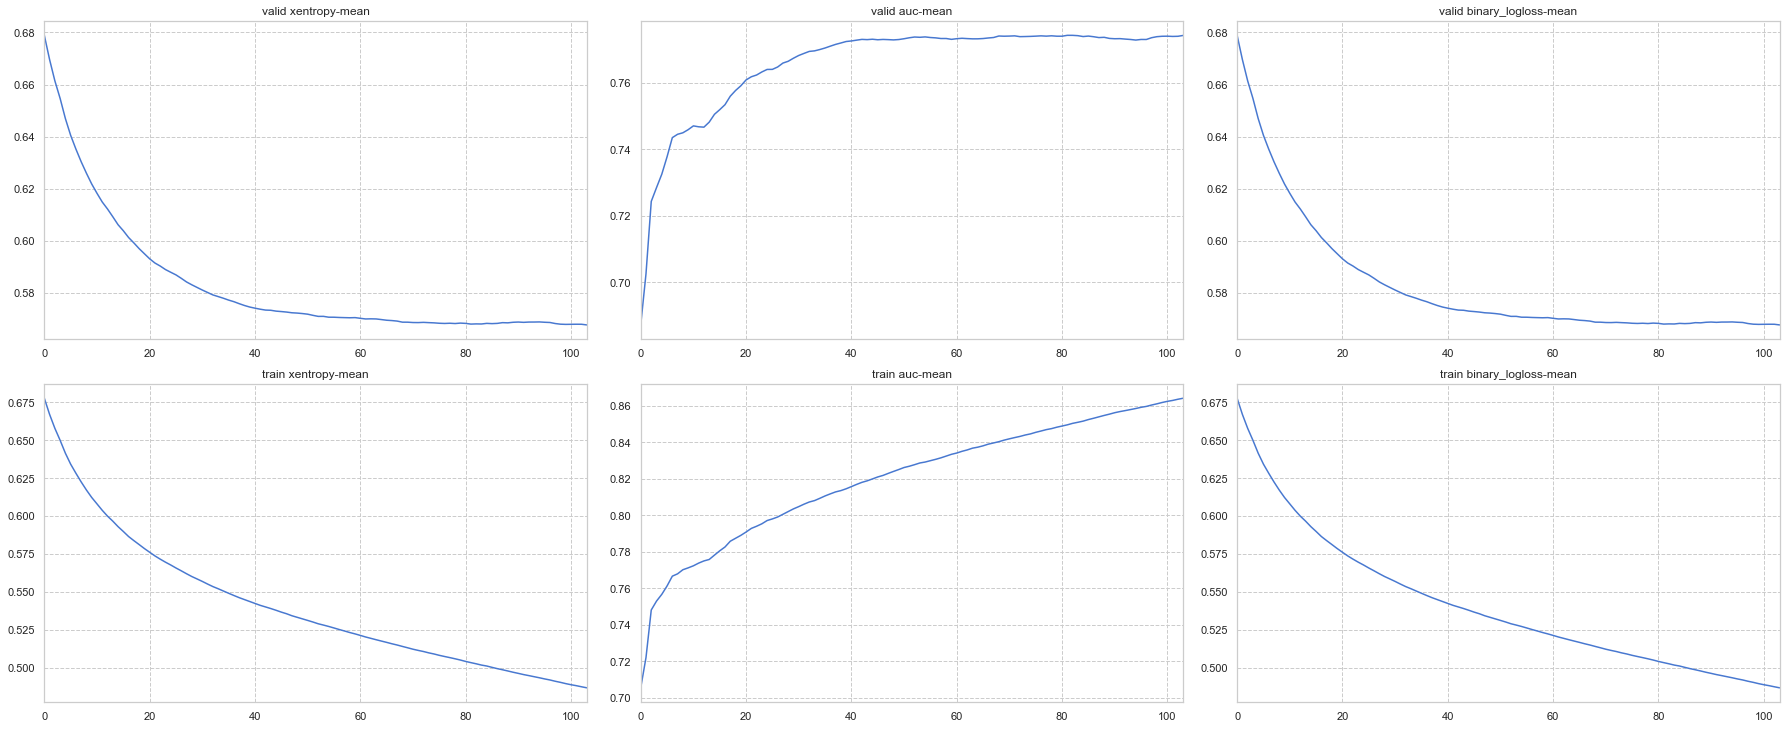


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('binary_logloss', 'xentropy', 'auc')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid bina

,train auc-mean,train auc-stdv,train xentropy-mean,train xentropy-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid auc-mean,valid auc-stdv,valid xentropy-mean,valid xentropy-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.861688,0.002259,0.489460,0.002139,0.489460,0.002139,0.773914,0.012689,0.567869,0.009902,0.567869,0.009902
100,0.862317,0.002210,0.488741,0.002174,0.488741,0.002174,0.773939,0.012767,0.567898,0.009931,0.567898,0.009931
101,0.862821,0.002213,0.488106,0.002191,0.488106,0.002191,0.773867,0.012762,0.567922,0.009937,0.567922,0.009937
102,0.863465,0.002138,0.487379,0.002094,0.487379,0.002094,0.773908,0.012827,0.567912,0.009919,0.567912,0.009919
103,0.864025,0.002097,0.486689,0.002089,0.486689,0.002089,0.774163,0.012813,0.567659,0.009976,0.567659,0.009976


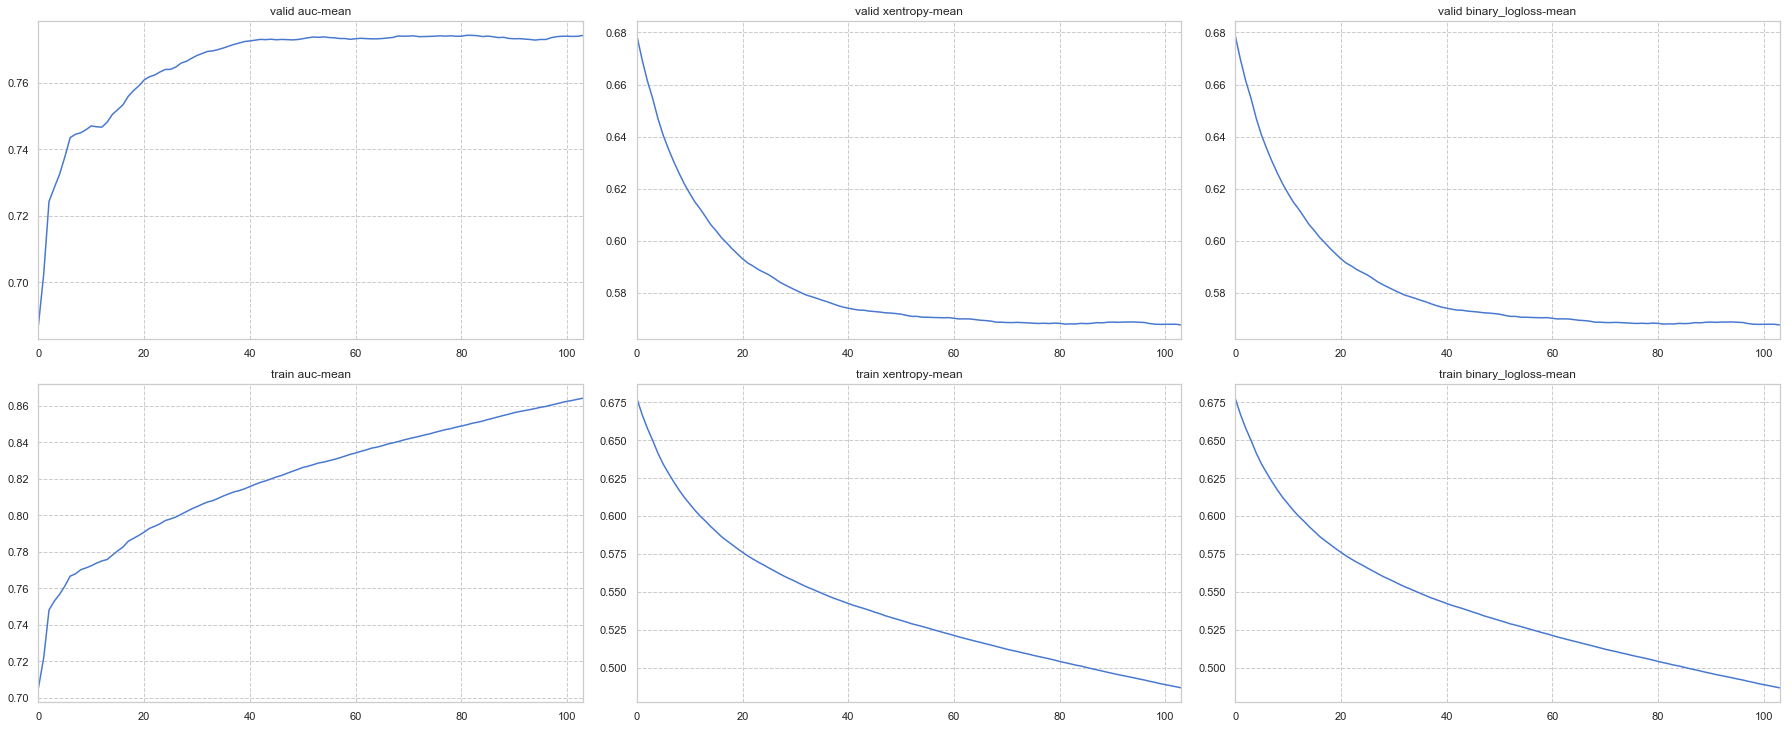


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('auc', 'binary_logloss', 'xentropy')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg

,train xentropy-mean,train xentropy-stdv,train binary_logloss-mean,train binary_logloss-stdv,train auc-mean,train auc-stdv,valid xentropy-mean,valid xentropy-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid auc-mean,valid auc-stdv
77,0.506604,0.001793,0.506604,0.001793,0.846830,0.002407,0.568303,0.010992,0.568303,0.010992,0.773952,0.014784
78,0.505829,0.001881,0.505829,0.001881,0.847386,0.002383,0.568192,0.010609,0.568192,0.010609,0.774053,0.014320
79,0.505010,0.001906,0.505010,0.001906,0.848161,0.002385,0.568357,0.010661,0.568357,0.010661,0.773936,0.014322
80,0.504091,0.002040,0.504091,0.002040,0.848802,0.002513,0.568247,0.010199,0.568247,0.010199,0.773933,0.013769
81,0.503292,0.002025,0.503292,0.002025,0.849456,0.002497,0.567977,0.010246,0.567977,0.010246,0.774197,0.013775


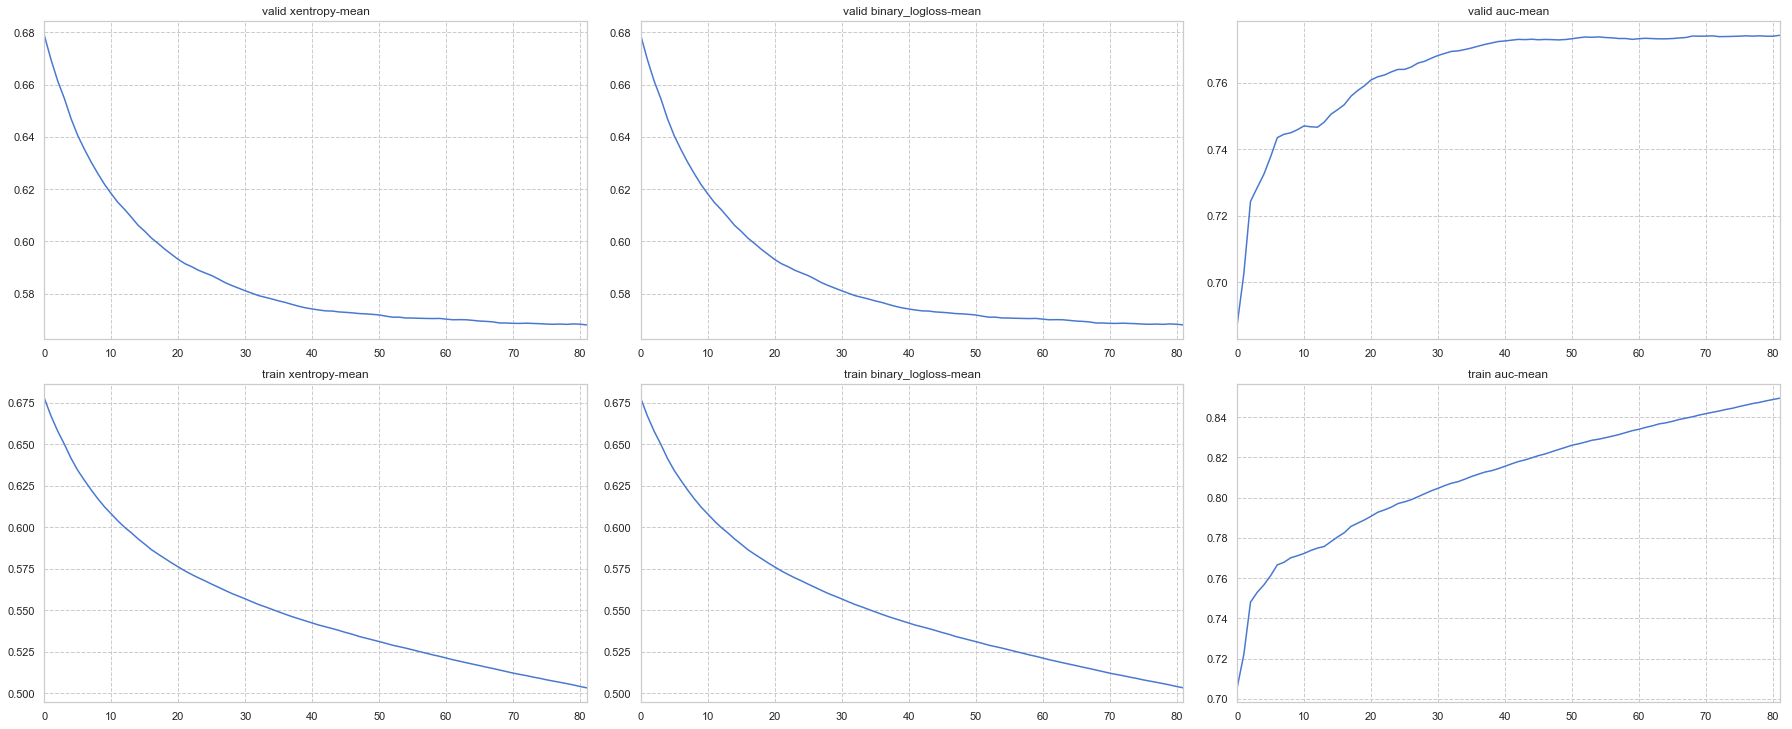


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('auc', 'xentropy', 'binary_logloss')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg

,train binary_logloss-mean,train binary_logloss-stdv,train xentropy-mean,train xentropy-stdv,train auc-mean,train auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid xentropy-mean,valid xentropy-stdv,valid auc-mean,valid auc-stdv
77,0.506604,0.001793,0.506604,0.001793,0.846830,0.002407,0.568303,0.010992,0.568303,0.010992,0.773952,0.014784
78,0.505829,0.001881,0.505829,0.001881,0.847386,0.002383,0.568192,0.010609,0.568192,0.010609,0.774053,0.014320
79,0.505010,0.001906,0.505010,0.001906,0.848161,0.002385,0.568357,0.010661,0.568357,0.010661,0.773936,0.014322
80,0.504091,0.002040,0.504091,0.002040,0.848802,0.002513,0.568247,0.010199,0.568247,0.010199,0.773933,0.013769
81,0.503292,0.002025,0.503292,0.002025,0.849456,0.002497,0.567977,0.010246,0.567977,0.010246,0.774197,0.013775


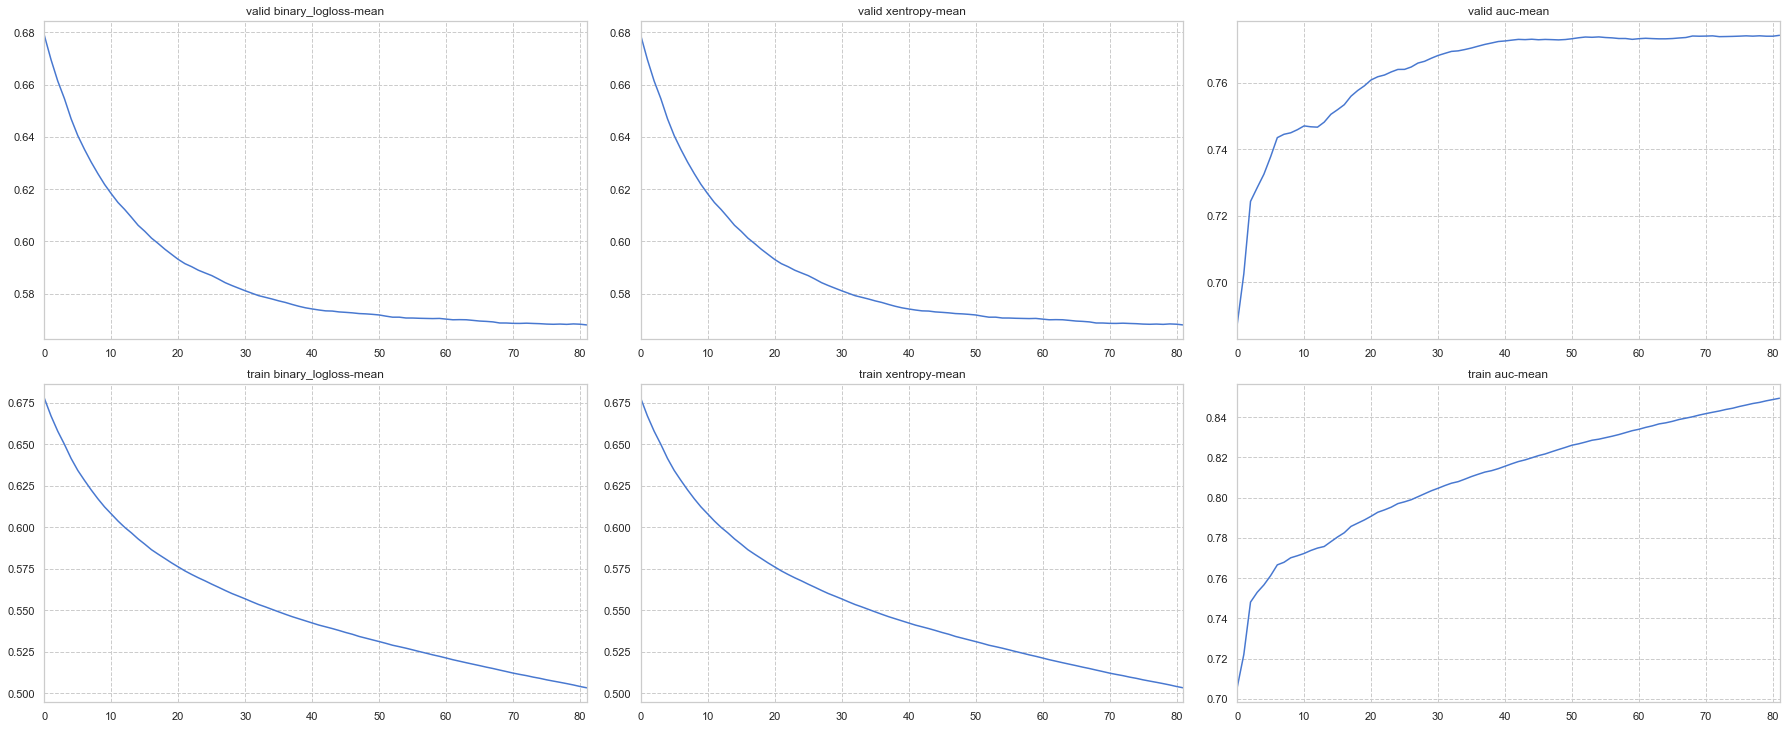


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('xentropy', 'binary_logloss', 'auc')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid xentropy: 0.572024 + 0.0108773
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid xentropy: 0.567869 + 0.00990152
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg's vali

,train auc-mean,train auc-stdv,train binary_logloss-mean,train binary_logloss-stdv,train xentropy-mean,train xentropy-stdv,valid auc-mean,valid auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid xentropy-mean,valid xentropy-stdv
99,0.861688,0.002259,0.489460,0.002139,0.489460,0.002139,0.773914,0.012689,0.567869,0.009902,0.567869,0.009902
100,0.862317,0.002210,0.488741,0.002174,0.488741,0.002174,0.773939,0.012767,0.567898,0.009931,0.567898,0.009931
101,0.862821,0.002213,0.488106,0.002191,0.488106,0.002191,0.773867,0.012762,0.567922,0.009937,0.567922,0.009937
102,0.863465,0.002138,0.487379,0.002094,0.487379,0.002094,0.773908,0.012827,0.567912,0.009919,0.567912,0.009919
103,0.864025,0.002097,0.486689,0.002089,0.486689,0.002089,0.774163,0.012813,0.567659,0.009976,0.567659,0.009976


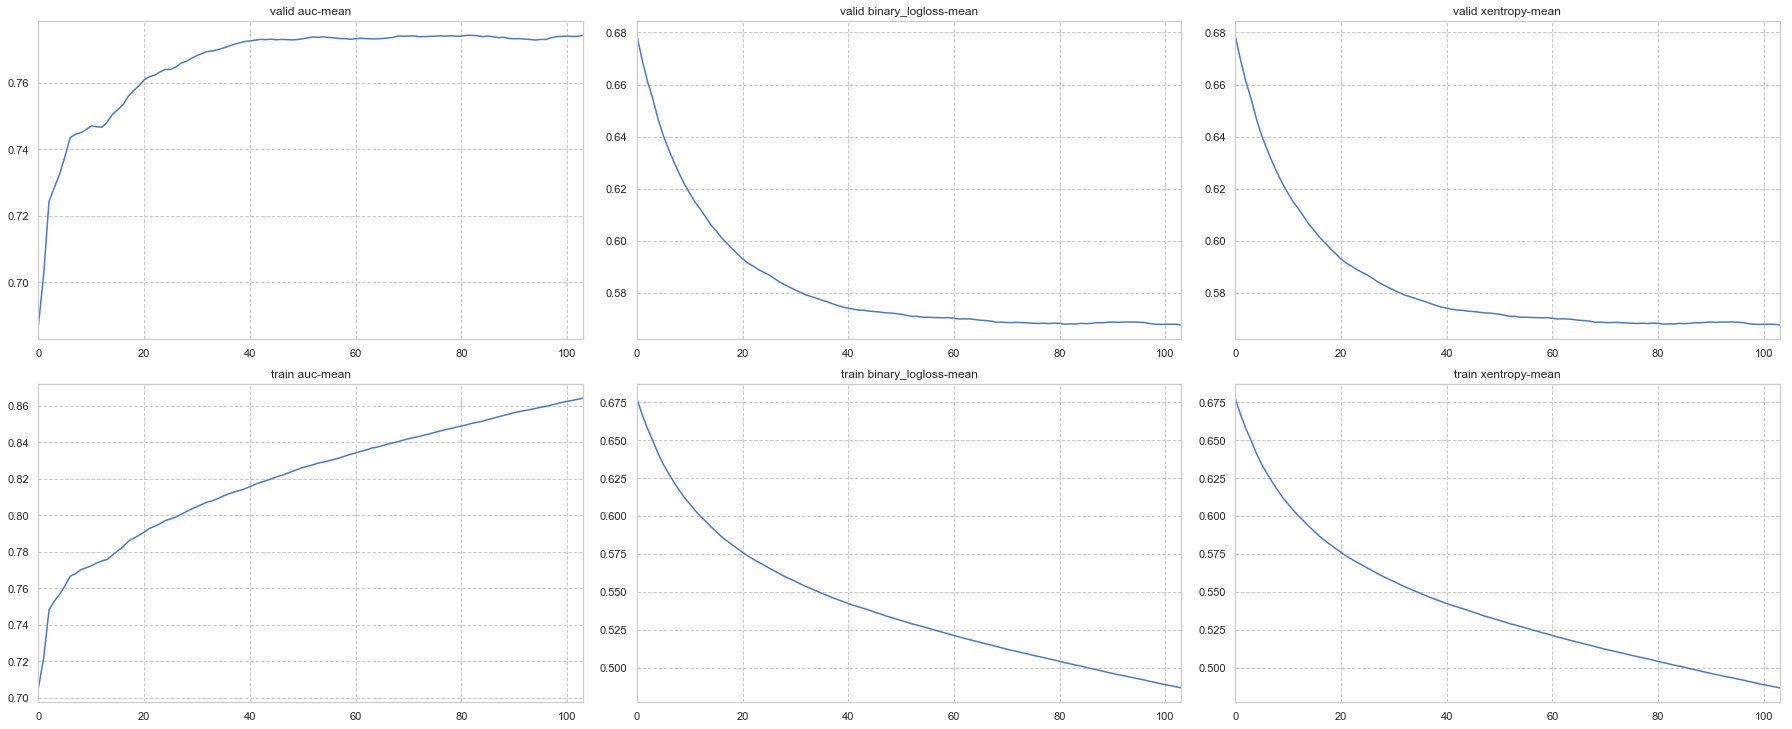


{'eval_train_metric': True, 'first_metric_only': True, 'metric_list': ('xentropy', 'auc', 'binary_logloss')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid xentropy: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid xentropy: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's vali

,train binary_logloss-mean,train binary_logloss-stdv,train auc-mean,train auc-stdv,train xentropy-mean,train xentropy-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid auc-mean,valid auc-stdv,valid xentropy-mean,valid xentropy-stdv
99,0.489460,0.002139,0.861688,0.002259,0.489460,0.002139,0.567869,0.009902,0.773914,0.012689,0.567869,0.009902
100,0.488741,0.002174,0.862317,0.002210,0.488741,0.002174,0.567898,0.009931,0.773939,0.012767,0.567898,0.009931
101,0.488106,0.002191,0.862821,0.002213,0.488106,0.002191,0.567922,0.009937,0.773867,0.012762,0.567922,0.009937
102,0.487379,0.002094,0.863465,0.002138,0.487379,0.002094,0.567912,0.009919,0.773908,0.012827,0.567912,0.009919
103,0.486689,0.002089,0.864025,0.002097,0.486689,0.002089,0.567659,0.009976,0.774163,0.012813,0.567659,0.009976


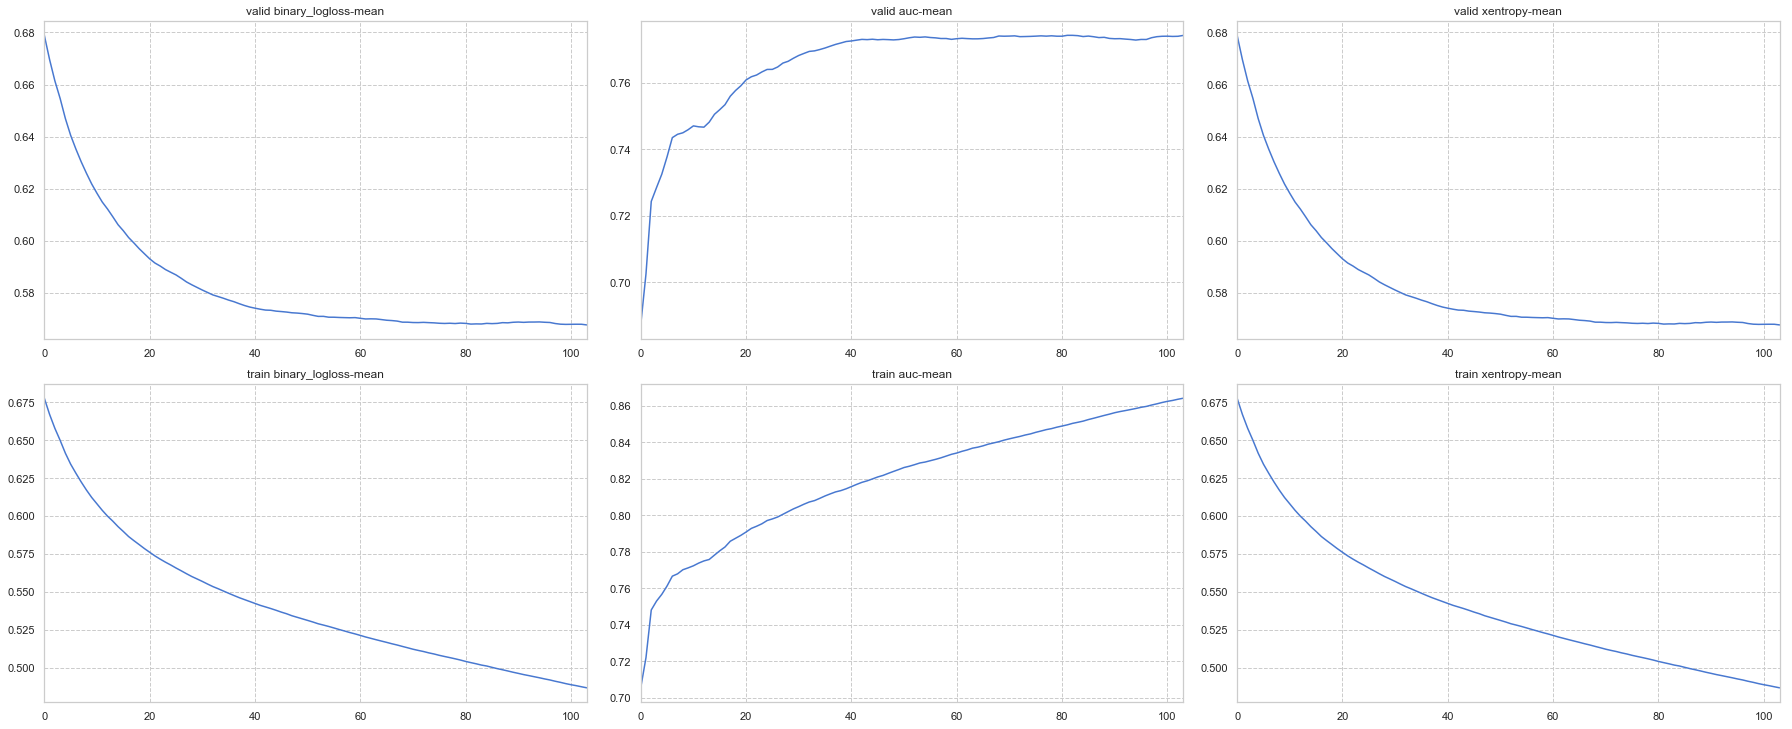


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': None}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


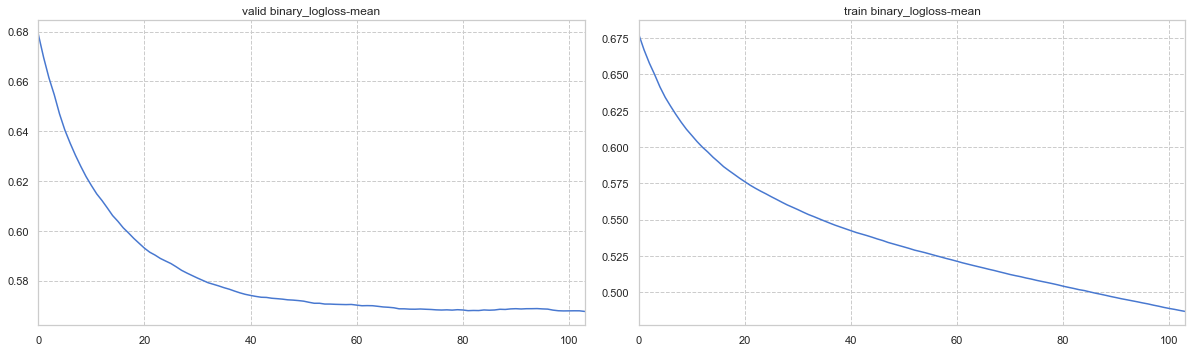


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ''}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


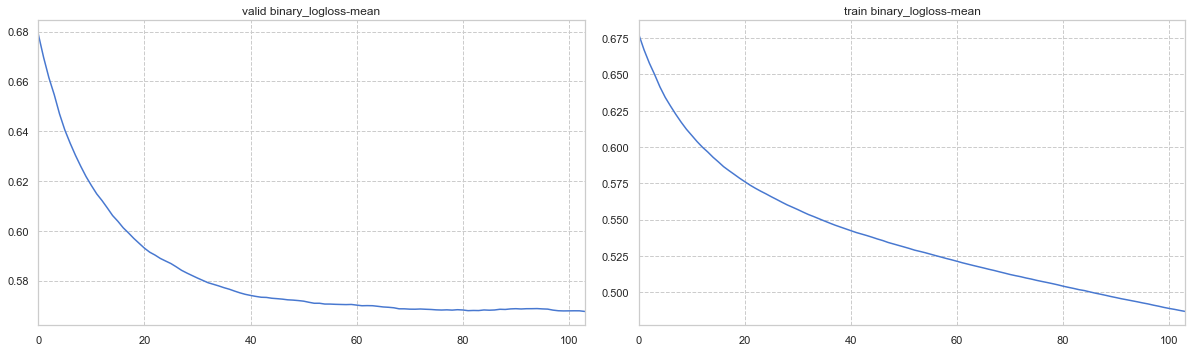


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'None'}

{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'binary_logloss'}
Training until validation scores don't improve for 100 rounds.


Traceback (most recent call last):
  File "<ipython-input-4-638847a97978>", line 12, in test_train
    num_boost_round=num_boost_round)
  File "<ipython-input-6-062582b93e8f>", line 55, in classification_train
    eval_train_metric=eval_train_metric,
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/engine.py", line 514, in cv
    evaluation_result_list=res))
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 215, in _callback
    _init(env)
  File "/Users/kenichi.matsui/Documents/996_github/LightGBM/python-package/lightgbm/callback.py", line 196, in _init
    raise ValueError('For early stopping, '
ValueError: For early stopping, at least one dataset and eval metric is required for evaluation


[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
[200]	cv_agg's train binary_logloss: 0.42645 + 0.00158453	cv_agg's valid binary_logloss: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train binary_logloss: 0.486689 + 0.00208938	cv_agg's valid binary_logloss: 0.567659 + 0.00997623


,train binary_logloss-mean,train binary_logloss-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


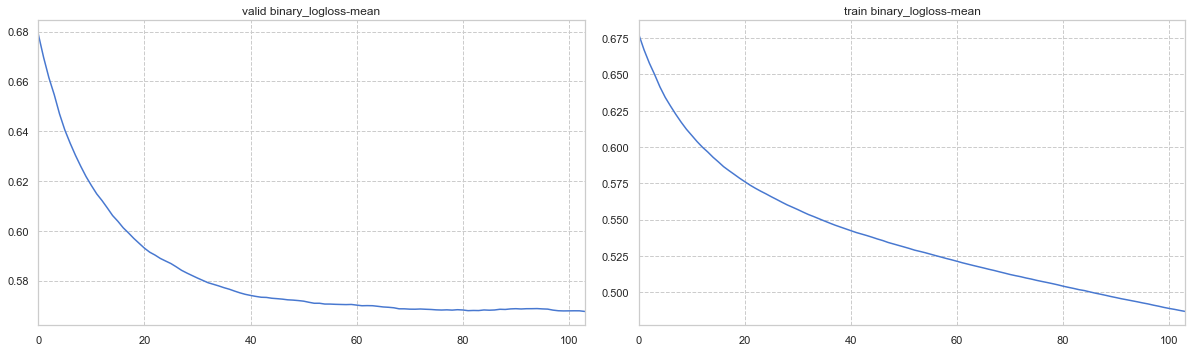


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'auc'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid auc: 0.77113 + 0.0116124
Early stopping, best iteration is:
[82]	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's valid auc: 0.774197 + 0.0137751


,train auc-mean,train auc-stdv,valid auc-mean,valid auc-stdv
77,0.846830,0.002407,0.773952,0.014784
78,0.847386,0.002383,0.774053,0.014320
79,0.848161,0.002385,0.773936,0.014322
80,0.848802,0.002513,0.773933,0.013769
81,0.849456,0.002497,0.774197,0.013775


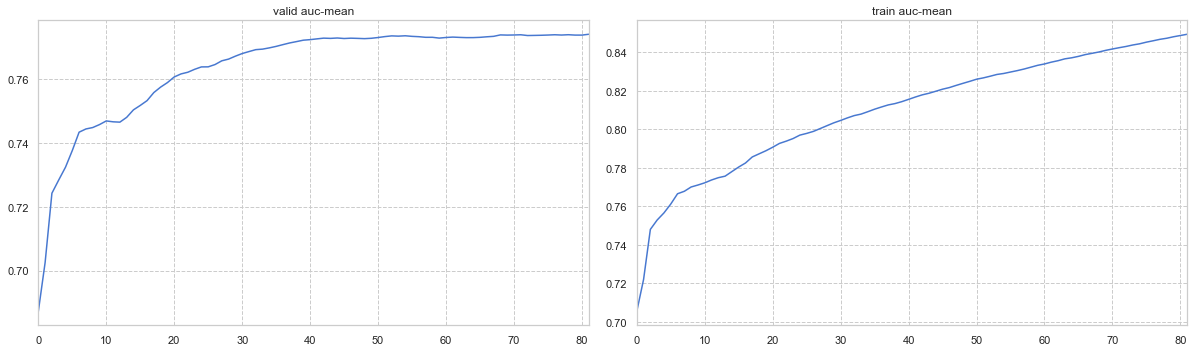


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': 'xentropy'}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's valid xentropy: 0.572024 + 0.0108773
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's valid xentropy: 0.567869 + 0.00990152
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's valid xentropy: 0.569961 + 0.00967098
[200]	cv_agg's train xentropy: 0.42645 + 0.00158453	cv_agg's valid xentropy: 0.572429 + 0.00905806
Early stopping, best iteration is:
[104]	cv_agg's train xentropy: 0.486689 + 0.00208938	cv_agg's valid xentropy: 0.567659 + 0.00997623


,train xentropy-mean,train xentropy-stdv,valid xentropy-mean,valid xentropy-stdv
99,0.489460,0.002139,0.567869,0.009902
100,0.488741,0.002174,0.567898,0.009931
101,0.488106,0.002191,0.567922,0.009937
102,0.487379,0.002094,0.567912,0.009919
103,0.486689,0.002089,0.567659,0.009976


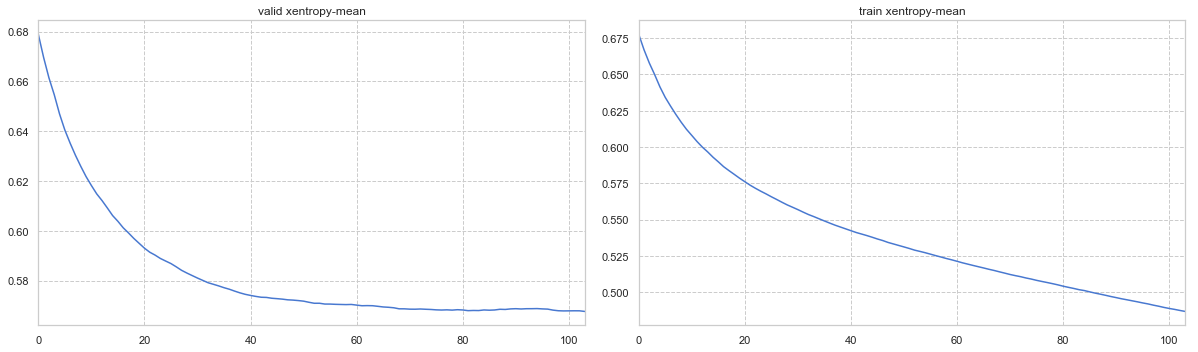


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('binary_logloss', 'auc')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid binary_logloss: 0.569961 + 0.00967098
Early stopping, best iteration is:
[82]	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's train binary_logloss: 0.503292 + 0.00202494	cv_agg's valid auc: 0.774197 + 0.0137751	cv_agg's valid binary_logloss: 0.567977 + 0.0102463


,train auc-mean,train auc-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid auc-mean,valid auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
77,0.846830,0.002407,0.506604,0.001793,0.773952,0.014784,0.568303,0.010992
78,0.847386,0.002383,0.505829,0.001881,0.774053,0.014320,0.568192,0.010609
79,0.848161,0.002385,0.505010,0.001906,0.773936,0.014322,0.568357,0.010661
80,0.848802,0.002513,0.504091,0.002040,0.773933,0.013769,0.568247,0.010199
81,0.849456,0.002497,0.503292,0.002025,0.774197,0.013775,0.567977,0.010246


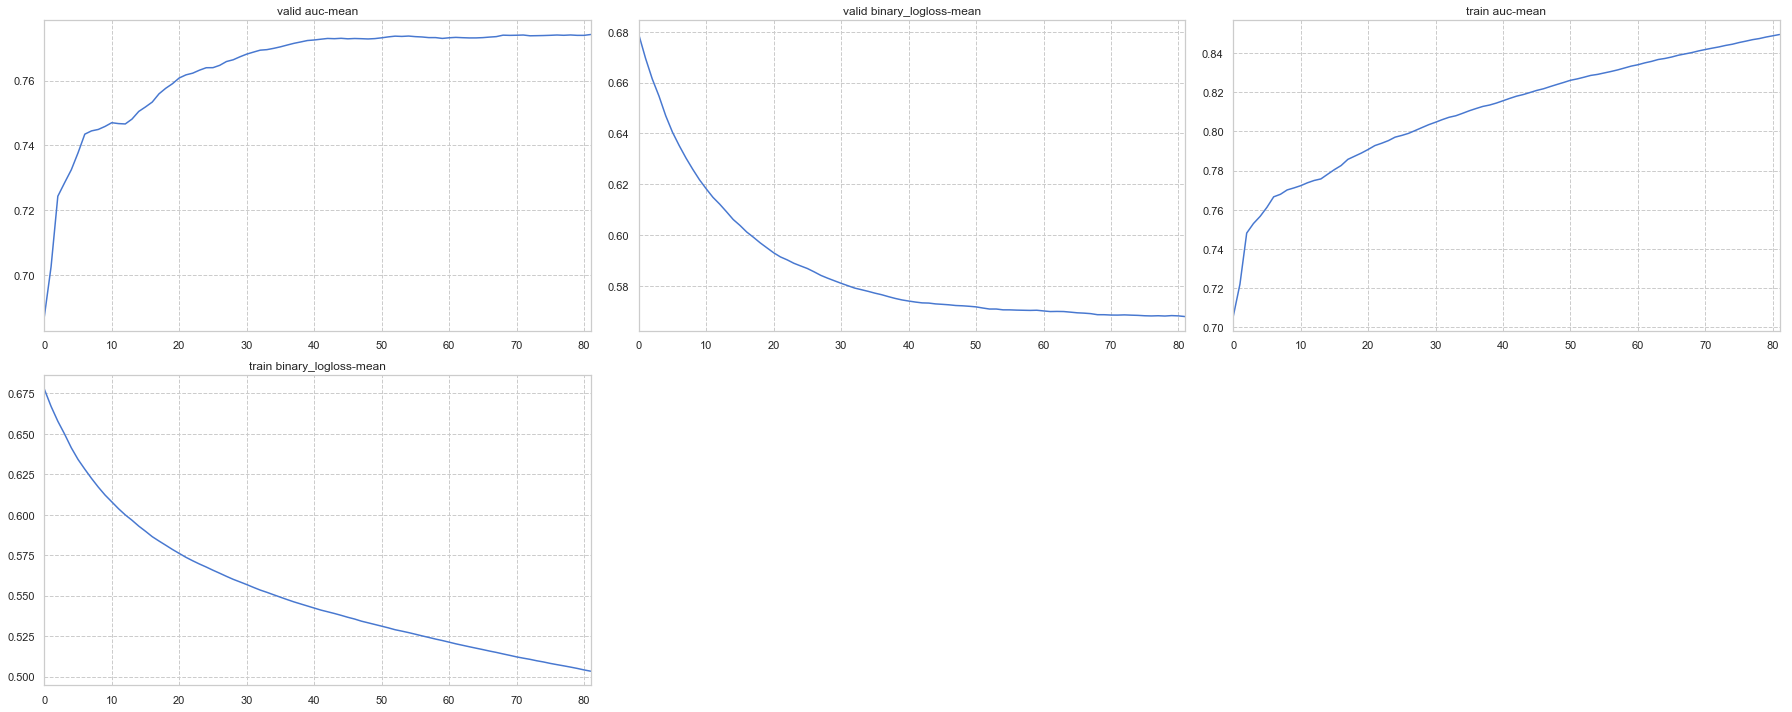


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('auc', 'binary_logloss')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_agg's valid auc: 0.77113 + 0.0116124
Early stopping, best iteration is:
[82]	cv_agg's train binary_logloss: 0.503292 + 0.00202494	cv_agg's train auc: 0.849456 + 0.00249654	cv_agg's valid binary_logloss: 0.567977 + 0.0102463	cv_agg's valid auc: 0.774197 + 0.0137751


,train binary_logloss-mean,train binary_logloss-stdv,train auc-mean,train auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid auc-mean,valid auc-stdv
77,0.506604,0.001793,0.846830,0.002407,0.568303,0.010992,0.773952,0.014784
78,0.505829,0.001881,0.847386,0.002383,0.568192,0.010609,0.774053,0.014320
79,0.505010,0.001906,0.848161,0.002385,0.568357,0.010661,0.773936,0.014322
80,0.504091,0.002040,0.848802,0.002513,0.568247,0.010199,0.773933,0.013769
81,0.503292,0.002025,0.849456,0.002497,0.567977,0.010246,0.774197,0.013775


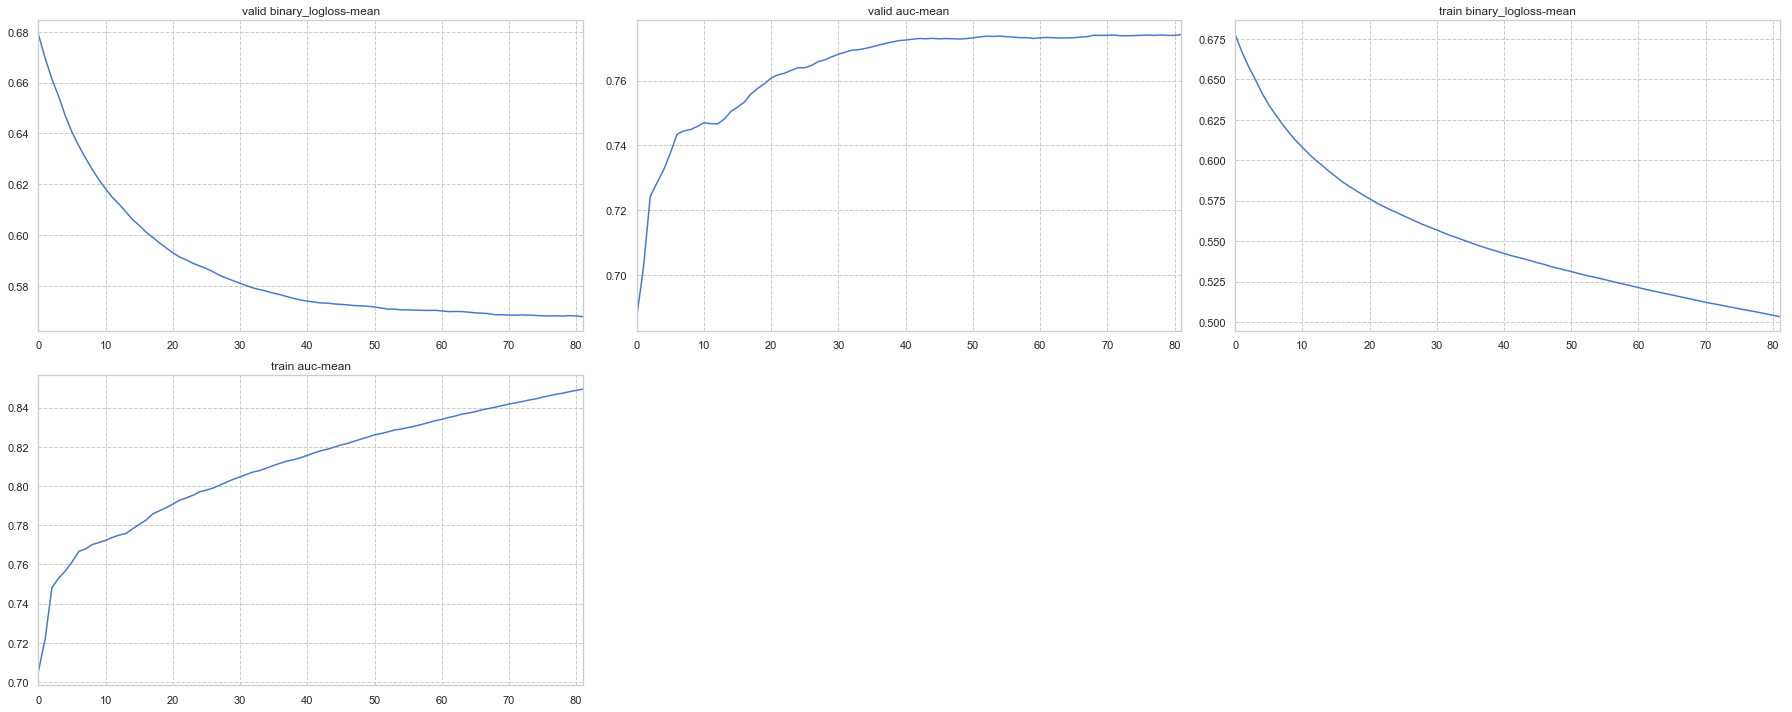


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('binary_logloss', 'auc', 'xentropy')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid bin

,train xentropy-mean,train xentropy-stdv,train auc-mean,train auc-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid xentropy-mean,valid xentropy-stdv,valid auc-mean,valid auc-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
77,0.506604,0.001793,0.846830,0.002407,0.506604,0.001793,0.568303,0.010992,0.773952,0.014784,0.568303,0.010992
78,0.505829,0.001881,0.847386,0.002383,0.505829,0.001881,0.568192,0.010609,0.774053,0.014320,0.568192,0.010609
79,0.505010,0.001906,0.848161,0.002385,0.505010,0.001906,0.568357,0.010661,0.773936,0.014322,0.568357,0.010661
80,0.504091,0.002040,0.848802,0.002513,0.504091,0.002040,0.568247,0.010199,0.773933,0.013769,0.568247,0.010199
81,0.503292,0.002025,0.849456,0.002497,0.503292,0.002025,0.567977,0.010246,0.774197,0.013775,0.567977,0.010246


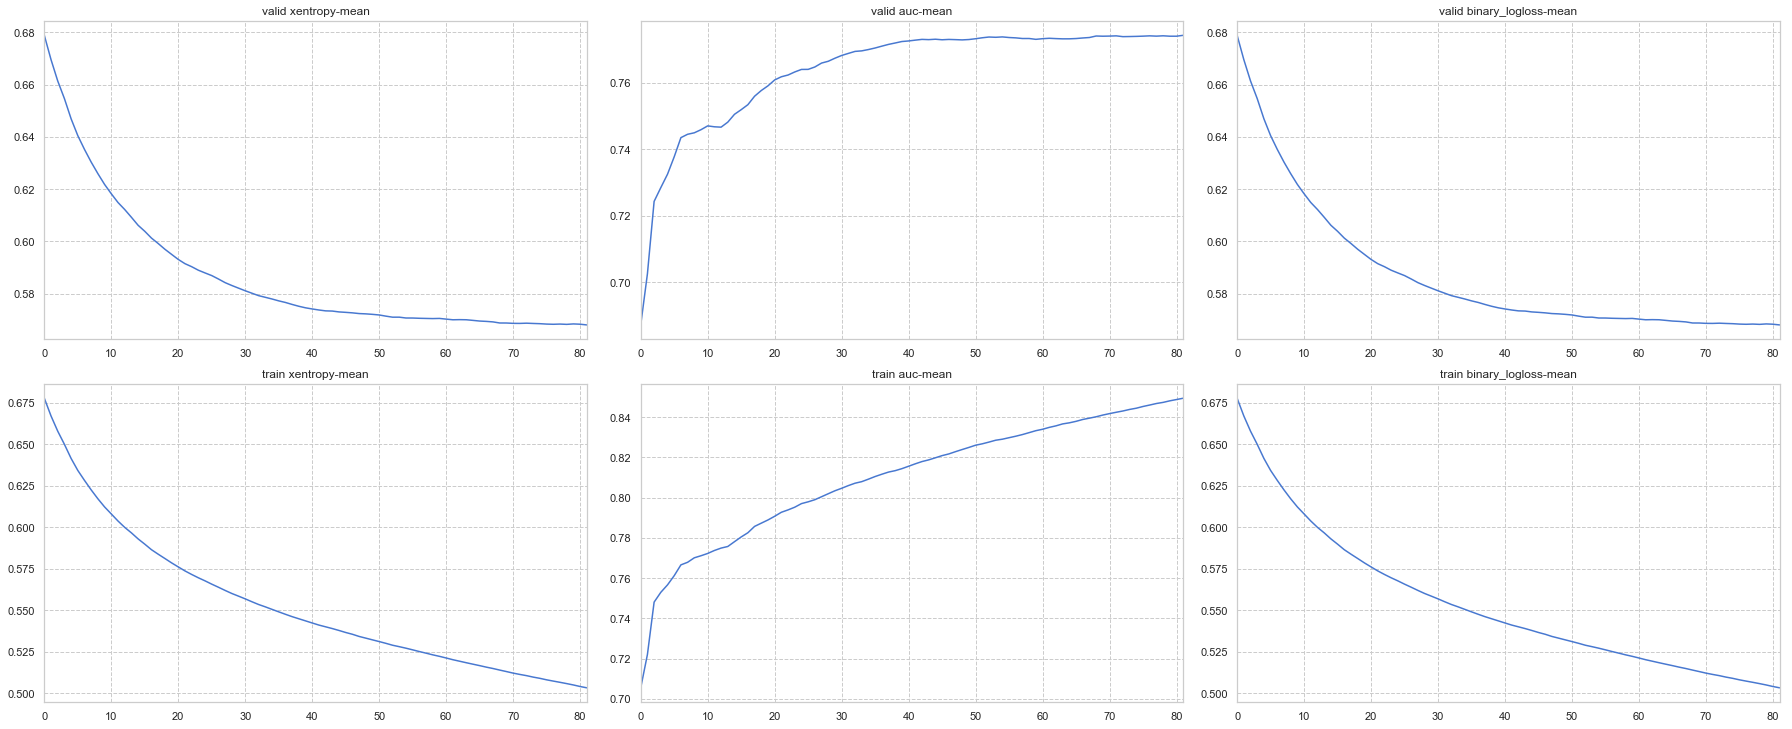


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('binary_logloss', 'xentropy', 'auc')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's valid auc: 0.772933 + 0.0160191	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid binary_logloss: 0.572024 + 0.0108773
[100]	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's valid auc: 0.773914 + 0.0126889	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid binary_logloss: 0.567869 + 0.00990152
[150]	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's valid auc: 0.77113 + 0.0116124	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid bin

,train auc-mean,train auc-stdv,train xentropy-mean,train xentropy-stdv,train binary_logloss-mean,train binary_logloss-stdv,valid auc-mean,valid auc-stdv,valid xentropy-mean,valid xentropy-stdv,valid binary_logloss-mean,valid binary_logloss-stdv
77,0.846830,0.002407,0.506604,0.001793,0.506604,0.001793,0.773952,0.014784,0.568303,0.010992,0.568303,0.010992
78,0.847386,0.002383,0.505829,0.001881,0.505829,0.001881,0.774053,0.014320,0.568192,0.010609,0.568192,0.010609
79,0.848161,0.002385,0.505010,0.001906,0.505010,0.001906,0.773936,0.014322,0.568357,0.010661,0.568357,0.010661
80,0.848802,0.002513,0.504091,0.002040,0.504091,0.002040,0.773933,0.013769,0.568247,0.010199,0.568247,0.010199
81,0.849456,0.002497,0.503292,0.002025,0.503292,0.002025,0.774197,0.013775,0.567977,0.010246,0.567977,0.010246


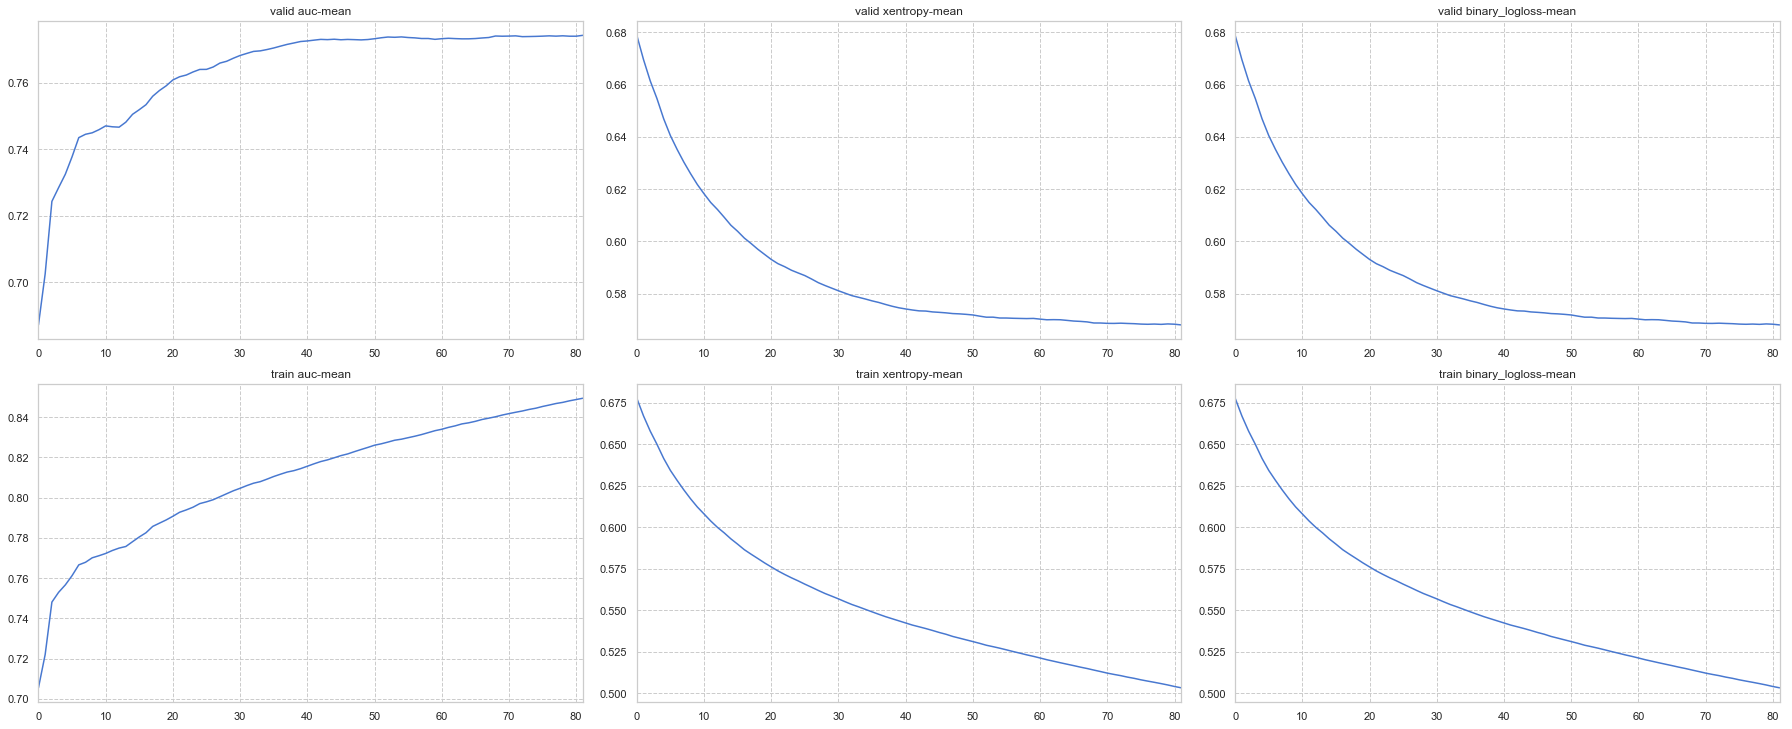


{'eval_train_metric': True, 'first_metric_only': False, 'metric_list': ('auc', 'binary_logloss', 'xentropy')}
Training until validation scores don't improve for 100 rounds.
[50]	cv_agg's train xentropy: 0.532171 + 0.00128254	cv_agg's train binary_logloss: 0.532171 + 0.00128254	cv_agg's train auc: 0.824993 + 0.00127279	cv_agg's valid xentropy: 0.572024 + 0.0108773	cv_agg's valid binary_logloss: 0.572024 + 0.0108773	cv_agg's valid auc: 0.772933 + 0.0160191
[100]	cv_agg's train xentropy: 0.48946 + 0.00213899	cv_agg's train binary_logloss: 0.48946 + 0.00213899	cv_agg's train auc: 0.861688 + 0.00225877	cv_agg's valid xentropy: 0.567869 + 0.00990152	cv_agg's valid binary_logloss: 0.567869 + 0.00990152	cv_agg's valid auc: 0.773914 + 0.0126889
[150]	cv_agg's train xentropy: 0.455745 + 0.00234033	cv_agg's train binary_logloss: 0.455745 + 0.00234033	cv_agg's train auc: 0.888403 + 0.00201446	cv_agg's valid xentropy: 0.569961 + 0.00967098	cv_agg's valid binary_logloss: 0.569961 + 0.00967098	cv_ag

,train xentropy-mean,train xentropy-stdv,train binary_logloss-mean,train binary_logloss-stdv,train auc-mean,train auc-stdv,valid xentropy-mean,valid xentropy-stdv,valid binary_logloss-mean,valid binary_logloss-stdv,valid auc-mean,valid auc-stdv
77,0.506604,0.001793,0.506604,0.001793,0.846830,0.002407,0.568303,0.010992,0.568303,0.010992,0.773952,0.014784
78,0.505829,0.001881,0.505829,0.001881,0.847386,0.002383,0.568192,0.010609,0.568192,0.010609,0.774053,0.014320
79,0.505010,0.001906,0.505010,0.001906,0.848161,0.002385,0.568357,0.010661,0.568357,0.010661,0.773936,0.014322
80,0.504091,0.002040,0.504091,0.002040,0.848802,0.002513,0.568247,0.010199,0.568247,0.010199,0.773933,0.013769
81,0.503292,0.002025,0.503292,0.002025,0.849456,0.002497,0.567977,0.010246,0.567977,0.010246,0.774197,0.013775


In [ ]:
test_train(classification_train, 
           param_func=classification_params,
           dataset=load_data_for_classification())

# Multi-label classification

In [ ]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [ ]:
def load_data_for_multi_label_classification():
    rd.seed(123)
    print('Loading data...')
    # Loading Iris Dataset
    iris = datasets.load_iris()
    X, y = iris.data, iris.target

    # Split dataset for this demonstration.
    X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    shuffle=True,
                                                    random_state=42)
    return X_train, y_train, X_test, y_test

def multi_label_classification_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500):
    X_train, y_train, X_test, y_test = dataset
    # one hot representation of y_train
    max_class_num = y_train.max()+1
    y_train_ohe = np.identity(max_class_num)[y_train]

    # Create LightGBM dataset for train.
    lgb_train = lgb.Dataset(X_train, y_train, free_raw_data=False)

    # LightGBM parameter
    params = {
        'boosting_type': 'gbdt',
        'objective': 'multiclass',
        'metric' :metric_list,
        # 'metric' : ["multi_logloss", "multi_error", ],
        'num_class': 3,
        'verbosity' : -1,
    }
    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
    eval_train_metric=True
    # # Fitting
    ret = lgb.cv(params=params,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 30,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   # return_boosters=True
                   )
    df_ret = pd.DataFrame(ret)
    display(df_ret.tail())
    return df_ret
    
def multi_classification_params():
    two_metrics = list(permutations(["multi_logloss", "multi_error", ], 2))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" : two_metrics + [
                          None, "", "None", "multi_logloss", "multi_error",  # just one metric
                        ] , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg

In [ ]:
test_train(multi_label_classification_train, 
           param_func=multi_classification_params, 
           dataset=load_data_for_multi_label_classification())

# Regression

In [ ]:
from sklearn.metrics import mean_absolute_error

In [ ]:
def load_data_for_regression():
    rd.seed(123)
    print('Loading data...')
    df_train = pd.read_csv('../../examples/regression/regression.train', header=None, sep='\t')
    df_test = pd.read_csv('../../examples/regression/regression.test', header=None, sep='\t')

    y_train = df_train[0]
    y_test = df_test[0]
    X_train = df_train.drop(0, axis=1)
    X_test = df_test.drop(0, axis=1)
    return X_train, y_train, X_test, y_test


def regression_train(dataset, metric_list=None, first_metric_only=True, eval_train_metric=True, num_boost_round=500):
    X_train, y_train, X_test, y_test = dataset
    
    lgb_train = lgb.Dataset(X_train, y_train)

    params = {
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'learning_rate': 0.5,
        'num_leaves': 5,
        #'metric': ['l1', 'l2'],
        'metric' :metric_list,
        'verbose': -1
    }

    callbacks = [
        lgb.early_stopping(stopping_rounds=100, first_metric_only=first_metric_only, verbose=True),
        #lgb.record_evaluation(res_dict)
    ]

    # Training settings
    FOLD_NUM = 5
    fold_seed = 71
    folds = StratifiedKFold(n_splits=FOLD_NUM, shuffle=True, random_state=fold_seed)
    eval_train_metric=True
    # # Fitting
    ret = lgb.cv(params=params,
                   train_set=lgb_train,
                   folds=folds,
                   num_boost_round=num_boost_round,
                   verbose_eval = 30,
                   callbacks=callbacks, 
                   eval_train_metric=eval_train_metric,
                   #return_boosters=True
                   )
    #print(f"best_iteration : {model.best_iteration}")

    df_ret = pd.DataFrame(ret)
    df_ret.tail()
    return df_ret

def regression_params():
    two_metrics = list(permutations(['l1','l2', ], 2))
    three_metrics = list(permutations(['l1','l2',  'rmse'], 3))

    param_grid = {
    #        "metric_list" : [two_metrics[0]], 
        "metric_list" : two_metrics + three_metrics + [
                          None, "", "None", 'l1','l2',  'rmse',  # just one metric
                        ] , 
        #"metric_list" : [""], 
        "first_metric_only": [True, False],
        "eval_train_metric": [True, False],
    }
    pg = ParameterGrid(param_grid)
    return pg

In [ ]:
test_train(regression_train, 
           param_func=regression_params, 
           dataset=load_data_for_regression())